In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pathlib
import os
import PIL
import random
import math

# Image manipulation.
from PIL import Image
from scipy.ndimage.filters import gaussian_filter

<br/><br/>
<font size='5'>
Utility functions for image manipulation
</font>


In [2]:
# Check for corrupted files in directory
def get_corrupted_files(data_dir, verbose=0, ret_split=0):
    """
    Checks for corrupted files in a directory

    data_dir: directory of the data as pathlib.Path object
    verbose: print out corrupted file paths and number of total corrupt images
    ret_split: return lists of verified and corrupted images
    """

    count_opened = 0
    count_error = 0
    good_file_urls = []
    bad_file_urls = []

    # Iterate through files in directory
    for filename in os.listdir(data_dir):
        # File extension control
        if (filename.endswith('.jpg') or filename.endswith('.png') or 
            filename.endswith('.bmp') or filename.endswith('.JPG') or 
            filename.endswith('.jpeg')):
        
            curr_img_path = data_dir.name +"/"+filename
            # try to open the image
            try:
                img = PIL.Image.open(curr_img_path) # open the image file
                img.verify() # verify that it is an image
                good_file_urls.append(curr_img_path) #add to 'good' files
                count_opened += 1

            # exception for corrupted file
            except (IOError, SyntaxError) as e:
                bad_file_urls.append(curr_img_path)
                count_error += 1
                if verbose > 1:
                    print('Bad file:', filename) # print out the names of corrupt files
                

    if verbose > 0:
        print(f"Checked: {count_opened+count_error}, verified: {count_opened}, corrupted: {count_error}")
    if ret_split > 0:
        return good_file_urls, bad_file_urls

In [3]:
# Transform image to numpy array
def img_to_np(file_url, max_dim=None):
    try:
        img = PIL.Image.open(file_url)
        if max_dim:
            img.thumbnail((max_dim, max_dim))
        img_np = np.array(img)
        return img_np

    except (IOError, SyntaxError) as e:
        print("bad file: ", file_url)

In [4]:
# MinMax normalization
def normalize_values(np_img):
    x_min = np_img.min()
    x_max = np_img.max()
    x_norm = (np_img - x_min) / (x_max - x_min)
    return x_norm

In [10]:
def show_np_img(np_img, use_pil=False, save_img=False):
    
    if use_pil:
        im = PIL.Image.fromarray(np_img)
        im.show()
    else:
        plt.imshow(np_img)

In [11]:
def save_image(image, filename, dir=''):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(dir+filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

<br/><br/>
<font size="5">
Gradient calculation functions
</font>

In [23]:
def get_tile_size(num_pixels, tile_size=400):
    """
    num_pixels is the number of pixels in a dimension of the image.
    tile_size is the desired tile-size.
    """

    # How many times can we repeat a tile of the desired size.
    num_tiles = int(round(num_pixels / tile_size))
    
    # Ensure that there is at least 1 tile.
    num_tiles = max(1, num_tiles)
    
    # The actual tile-size.
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    
    return actual_tile_size

In [24]:
def tiled_gradient(gradient, image, tile_size=400):
    # Allocate an array for the gradient of the entire image.
    grad = np.zeros_like(image)

    # Number of pixels for the x- and y-axes.
    x_max, y_max, _ = image.shape

    # Tile-size for the x-axis.
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    # 1/4 of the tile-size.
    x_tile_size4 = x_tile_size // 4

    # Tile-size for the y-axis.
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    # 1/4 of the tile-size
    y_tile_size4 = y_tile_size // 4

    # Random start-position for the tiles on the x-axis.
    # The random value is between -3/4 and -1/4 of the tile-size.
    # This is so the border-tiles are at least 1/4 of the tile-size,
    # otherwise the tiles may be too small which creates noisy gradients.
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)

    while x_start < x_max:
        # End-position for the current tile.
        x_end = x_start + x_tile_size
        
        # Ensure the tile's start- and end-positions are valid.
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)

        # Random start-position for the tiles on the y-axis.
        # The random value is between -3/4 and -1/4 of the tile-size.
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            # End-position for the current tile.
            y_end = y_start + y_tile_size

            # Ensure the tile's start- and end-positions are valid.
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)

            # Get the image-tile.
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]

            # Create a feed-dict with the image-tile.
            feed_dict = model.create_feed_dict(image=img_tile)

            # Use TensorFlow to calculate the gradient-value.
            g = session.run(gradient, feed_dict=feed_dict)

            # Normalize the gradient for the tile. This is
            # necessary because the tiles may have very different
            # values. Normalizing gives a more coherent gradient.
            g /= (np.std(g) + 1e-8)

            # Store the tile's gradient at the appropriate location.
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            
            # Advance the start-position for the y-axis.
            y_start = y_end

        # Advance the start-position for the x-axis.
        x_start = x_end

    return grad

In [27]:
def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    
    print("Image before:")
    plot_image(img)

    print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    
    for i in range(num_iterations):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img,
                              tile_size=tile_size)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled

        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    print()
    print("Image after:")
    plot_image(img)
    
    return img

In [28]:
def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)

    # Process the image using the DeepDream algorithm.
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

<br/><br/>
<font size='5'>
Implementation
</font>

In [20]:
# Paths to data
data_url = 'example_images/'
data_dir = pathlib.Path(data_url)

save_url = 'created_images/'

# Lets see our number of samples
train_image_count = len(list(data_dir.glob('*.*')))
print("Items in directory:",train_image_count)

Items in directory: 10


In [16]:
good_urls, bas_urls = get_corrupted_files(data_dir,verbose=1, ret_split=1)

Checked: 10, verified: 10, corrupted: 0


In [17]:
example_img = img_to_np(good_urls[0], max_dim=1000)
example_img.shape

(667, 1000, 3)

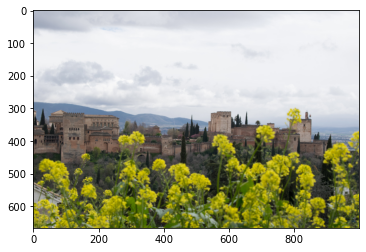

In [18]:
show_np_img(example_img)

In [29]:
# Base model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [36]:
base_model.layers